# Set up

Firstly, make sure to set up GPU usage on this notebook: Runtime -> Change runtime type -> T4 GPU.

Mount your drive to the notebook and set up the project directory where we will save our models. Everything is going to save in a directory in your drive called $\texttt{symbolic_distillation_GNNs_demo}$.

In [21]:
# ===== PROJECT SETUP =====
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
# Set project directory (adjust path to match your folder structure)

project_dir = '/content/drive/MyDrive/symbolic_disillation_GNNs_demo'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Files in project folder: {os.listdir('.')}")

# Now your saved models will be in your project folder
script_dir = project_dir

Mounted at /content/drive
Working directory: /content/drive/MyDrive/symbolic_disillation_GNNs_demo
Files in project folder: ['__pycache__', 'simulations', 'utils.py', 'model.py', 'datasets', 'train_val_test_data', 'model_weights', 'plot_linear_rep.py', 'pruning_experiments.py', 'linrepr_plots']


Import the required libraries.

In [22]:
!pip install torch-geometric accelerate wandb celluloid

Fetch the relevent scripts from the project repository.

In [23]:
!mkdir -p simulations
!wget https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/simulations/simulate.py -O simulations/simulate.py
!wget https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/simulations/generate_data.py -O simulations/generate_data.py
!wget https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/model.py -O model.py
!wget https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/utils.py -O utils.py

--2025-06-21 10:39:46--  https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/simulations/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9846 (9.6K) [text/plain]
Saving to: ‘simulations/simulate.py’

simulations/simulat 100%[===================>]   9.62K  --.-KB/s    in 0.001s  

2025-06-21 10:39:46 (15.2 MB/s) - ‘simulations/simulate.py’ saved [9846/9846]

--2025-06-21 10:39:46--  https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/simulations/generate_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP re

# Generate the dataset

We need to generate the dataset. Choose which simulation you want to run.

In [24]:
sim = 'spring' #change to either 'charge', 'r1', 'r2', 'spring'

Run the below cell to generate data. This does not take very long. The dataset will be saved in the $\texttt{datasets}$ folder.\
By default, we always use four particles in two dimensions.

In [ ]:
!python3 simulations/generate_data.py --sim $sim --save

Running on spring_n=4_dim=2_nt=1000_dt=0.01


# Run the models

In [25]:
from model import *
from utils import *

In [ ]:
#These are the different locations for where the datasets are saved

dataset_locations = {
    'charge': 'datasets/charge_n=4_dim=2_nt=1000_dt=0.001.pt',
    'r1': 'datasets/r1_n=4_dim=2_nt=1000_dt=0.005.pt',
    'r2': 'datasets/r2_n=4_dim=2_nt=1000_dt=0.001.pt',
    'spring': 'datasets/spring_n=4_dim=2_nt=1000_dt=0.01.pt',
}

In [27]:
#create the train, test and validation sets
train_data, val_data, test_data = load_and_process(dataset_locations[sim], seed=290402)

Choose the model type that you want to run.

In [28]:
model_type = 'bottleneck' #change to either 'standard', 'bottleneck', 'L1', 'KL', 'pruning'

We can train for a small number of epochs (equivalent to 330k optimiser steps) for sake of time. With 30 epochs and below, we use the OneCycleLR scheduler for fast training.
For the results in the project report, we trained for 200 epochs (1.1 million steps). You can change the below to 200 epochs and the scheduler will automatically change to Cosine Annealing.

In [29]:
epochs = 30

If you want to turn on $\texttt{wandb}$ logging, you need to log in first. Uncomment the cell below.

In [ ]:
#! wandb login

Train the model. This should take around 30 mins but it saves so we can access the model weights later.

In [ ]:
model = create_model(model_type = model_type)

#if it's the pruning model we have to set the schedule
if model_type == 'pruning':
    model.set_pruning_schedule(epochs, schedule='cosine', end_epoch_frac=0.65)
model = train(model, train_data=train_data, val_data=val_data, dataset_name = sim, num_epoch=epochs,
              save=True, wandb_log=False) #turn wandb_log = True if you want to log using wandb

Running on cuda.


Epoch 1/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.19it/s]


training loss: 11.4784, val loss: 8.2432


Epoch 2/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.74it/s]


training loss: 6.3814, val loss: 5.2108


Epoch 3/30: 100%|█████████▉| 10937/10938 [01:17<00:00, 140.72it/s]


training loss: 4.0499, val loss: 3.0020


Epoch 4/30: 100%|█████████▉| 10937/10938 [01:17<00:00, 140.79it/s]


training loss: 3.4051, val loss: 2.3690


Epoch 5/30: 100%|█████████▉| 10937/10938 [01:17<00:00, 141.46it/s]


training loss: 2.6898, val loss: 1.8834


Epoch 6/30: 100%|█████████▉| 10937/10938 [01:17<00:00, 141.15it/s]


training loss: 2.1928, val loss: 1.7893


Epoch 7/30: 100%|█████████▉| 10937/10938 [01:17<00:00, 141.47it/s]


training loss: 1.9787, val loss: 1.7471


Epoch 8/30: 100%|█████████▉| 10937/10938 [01:17<00:00, 141.11it/s]


training loss: 1.8237, val loss: 1.5799


Epoch 9/30: 100%|█████████▉| 10937/10938 [01:21<00:00, 133.67it/s]


training loss: 1.6737, val loss: 1.5621


Epoch 10/30: 100%|█████████▉| 10937/10938 [01:19<00:00, 138.41it/s]


training loss: 1.5351, val loss: 0.9611


Epoch 11/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 138.80it/s]


training loss: 1.4200, val loss: 1.1279


Epoch 12/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 138.53it/s]


training loss: 1.2915, val loss: 0.9443


Epoch 13/30: 100%|█████████▉| 10937/10938 [01:19<00:00, 138.09it/s]


training loss: 1.1870, val loss: 0.9733


Epoch 14/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 138.54it/s]


training loss: 1.1047, val loss: 1.0856


Epoch 15/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 138.47it/s]


training loss: 1.0216, val loss: 0.8539


Epoch 16/30: 100%|█████████▉| 10937/10938 [01:19<00:00, 137.36it/s]


training loss: 0.9222, val loss: 0.6222


Epoch 17/30: 100%|█████████▉| 10937/10938 [01:19<00:00, 136.98it/s]


training loss: 0.8335, val loss: 0.5384


Epoch 18/30: 100%|█████████▉| 10937/10938 [01:19<00:00, 136.81it/s]


training loss: 0.7471, val loss: 0.8036


Epoch 19/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 138.45it/s]


training loss: 0.6823, val loss: 0.5379


Epoch 20/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.57it/s]


training loss: 0.6023, val loss: 0.5633


Epoch 21/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.38it/s]


training loss: 0.5169, val loss: 0.4067


Epoch 22/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.58it/s]


training loss: 0.4542, val loss: 0.4351


Epoch 23/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.05it/s]


training loss: 0.3946, val loss: 0.3564


Epoch 24/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.33it/s]


training loss: 0.3381, val loss: 0.2717


Epoch 25/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 140.07it/s]


training loss: 0.2878, val loss: 0.2619


Epoch 26/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.52it/s]


training loss: 0.2523, val loss: 0.2688


Epoch 27/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.12it/s]


training loss: 0.2241, val loss: 0.2106


Epoch 28/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.74it/s]


training loss: 0.2058, val loss: 0.1959


Epoch 29/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 140.03it/s]


training loss: 0.1944, val loss: 0.1909


Epoch 30/30: 100%|█████████▉| 10937/10938 [01:18<00:00, 139.33it/s]


training loss: 0.1892, val loss: 0.1888


The model weights and also the $\texttt{.json}$ metrics file will be saved at $\texttt{model_weights/sim/model_type}$ in this demo folder. Let's load the model now and analyse the messages.

# Plot the linear combination of forces

Load the model.

In [30]:
model = load_model(sim, model_type, epochs)

Model loaded successfully.


Get the code to fit and plot the linear combination of true forces to the messages.

In [31]:
!wget https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/plot_linear_rep.py -O plot_linear_rep.py
!wget https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/pruning_experiments.py -O pruning_experiments.py

--2025-06-21 10:40:08--  https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/plot_linear_rep.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23053 (23K) [text/plain]
Saving to: ‘plot_linear_rep.py’

plot_linear_rep.py  100%[===================>]  22.51K  --.-KB/s    in 0.002s  

2025-06-21 10:40:08 (13.4 MB/s) - ‘plot_linear_rep.py’ saved [23053/23053]

--2025-06-21 10:40:08--  https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/pruning_experiments.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

In [32]:
from plot_linear_rep import *

The following code will
1. Pass the test set through the trained model and obtain the messages from the outputs of the edge model.
2. Pick the two best message elements (for standard and L1, this if the elements with the highest std. For KL, these are elements with the highest KL divergence. For pruning and bottleneck, there are only two elements).
3. Perform a linear regression on the true forces in the $x$ and $y$ direction and to fit the two most important message elements. One linear regression includes all points, the other ignores the worst 10% of outliers (robust fit).
4. Get the $R^2$ value of both fits. For the robust fit, we again ignore the outliers for calculating $R^2$.

![msg_lin_comb (2).png](<attachment:msg_lin_comb (2).png>)

Extracting message features.
Fitting the forces to the two most important messages - robust.
robust score:  0.0006197500642884681
ROBUST Message 1 R2 Score: 0.99919
ROBUST Message 2 R2 Score: 0.9993
Fitting the forces to the two most important messages - including outliers.


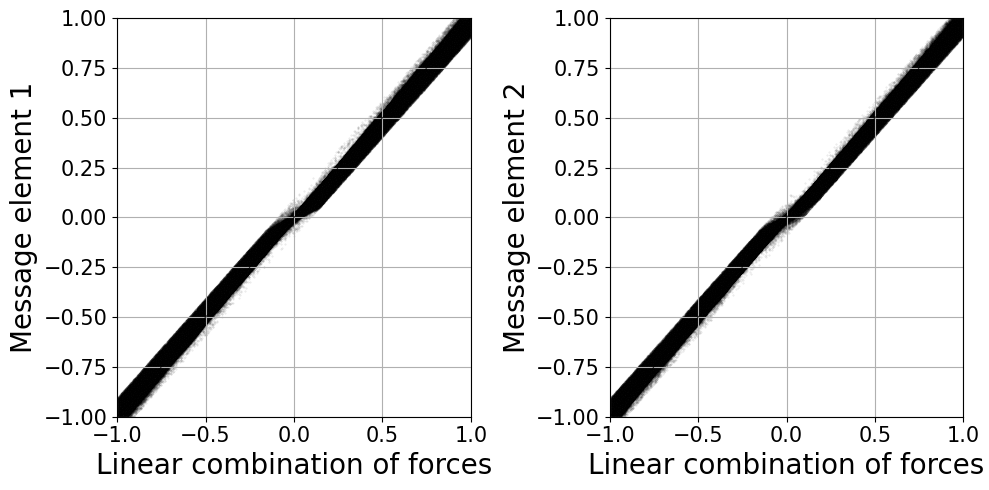

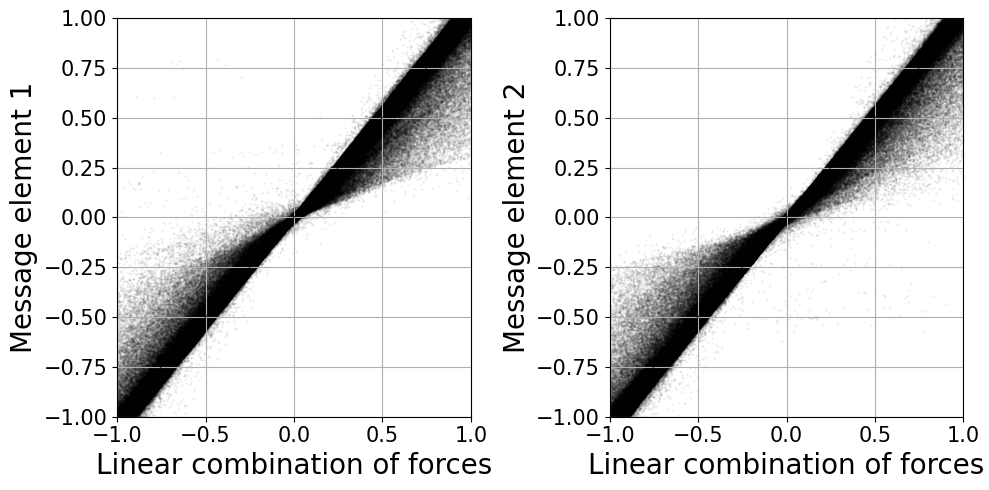

In [33]:
r2_scores_tuple, fig = plot_linear_representation(model, test_data, sim, model_type, epochs)

The first row in the above plot is the linear fit without outliers removed and the second one includes outliers.

In [34]:
print(f'R2 score for messages without outliers: {r2_scores_tuple[0]}')
print(f'R2 score for messages with outliers: {r2_scores_tuple[1]}')

R2 score for messages without outliers: (0.9991937544984572, 0.9992988959155876)
R2 score for messages with outliers: (0.9836882172103723, 0.9833872820675014)


# Symbolic regression

Install *PySR*.

In [35]:
!pip install -U pysr

In [36]:
!wget https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/symbolic_reg.py -O symbolic_reg.py

--2025-06-21 10:41:37--  https://raw.githubusercontent.com/elizabethsztan/symbolic_distillation_GNNs/main/symbolic_reg.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7849 (7.7K) [text/plain]
Saving to: ‘symbolic_reg.py’

symbolic_reg.py     100%[===================>]   7.67K  --.-KB/s    in 0.001s  

2025-06-21 10:41:37 (6.54 MB/s) - ‘symbolic_reg.py’ saved [7849/7849]



These are the forms of the equations that we would expect for the different simulations.

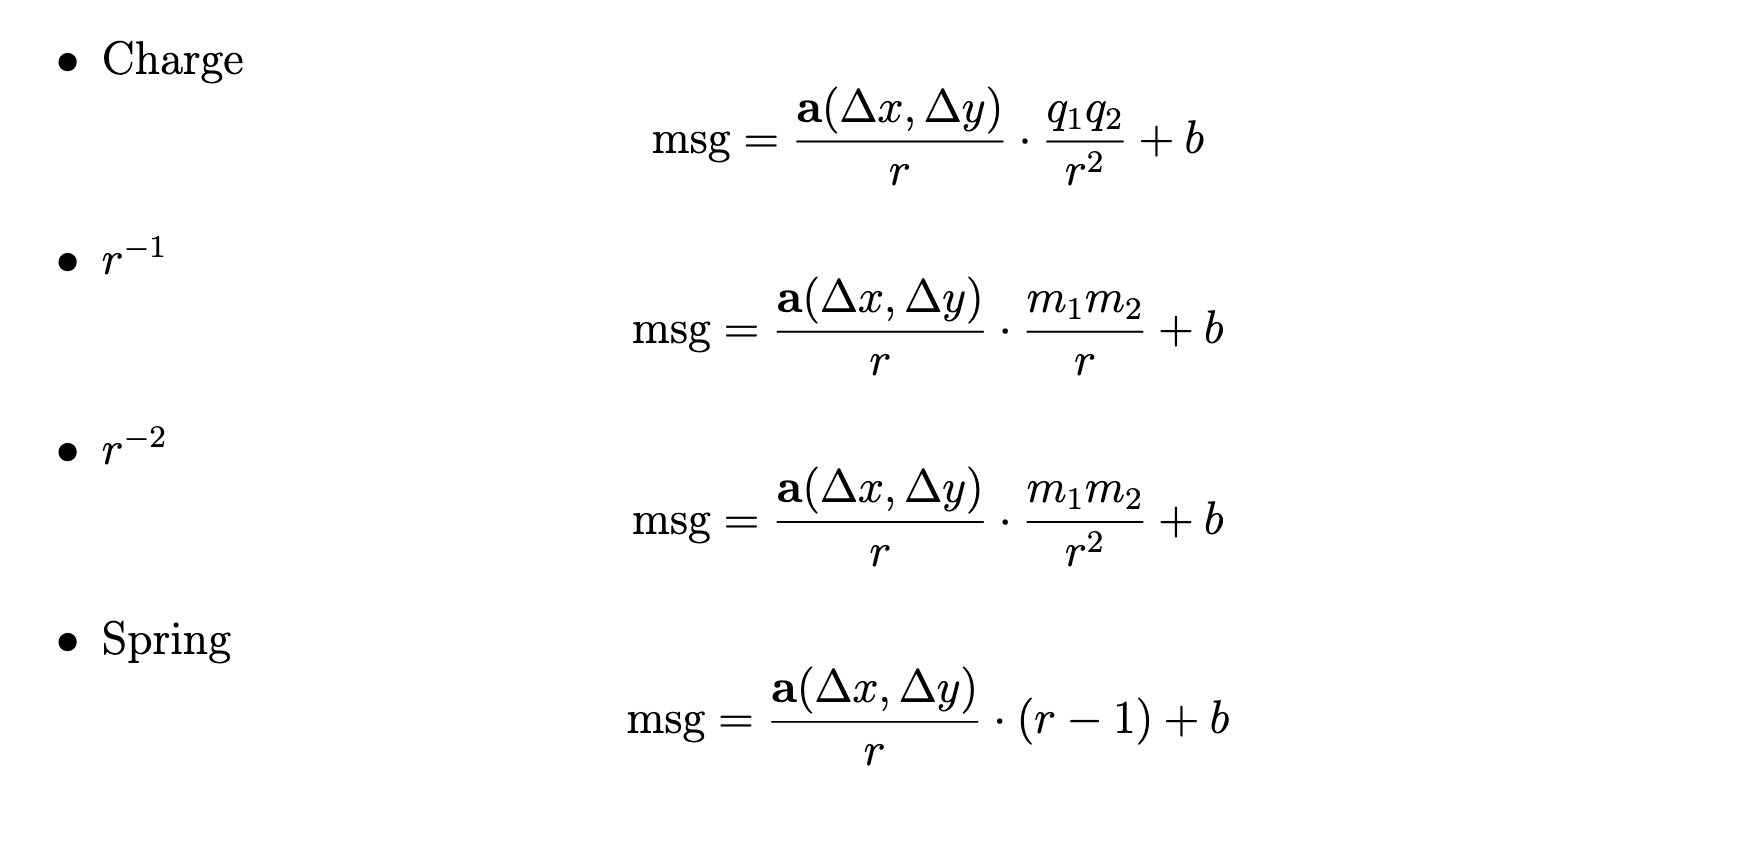

We cannot say what precise equation that we will reconstruct. Also reconstruction is not always possible. See the results on what simulations/model types were successful:

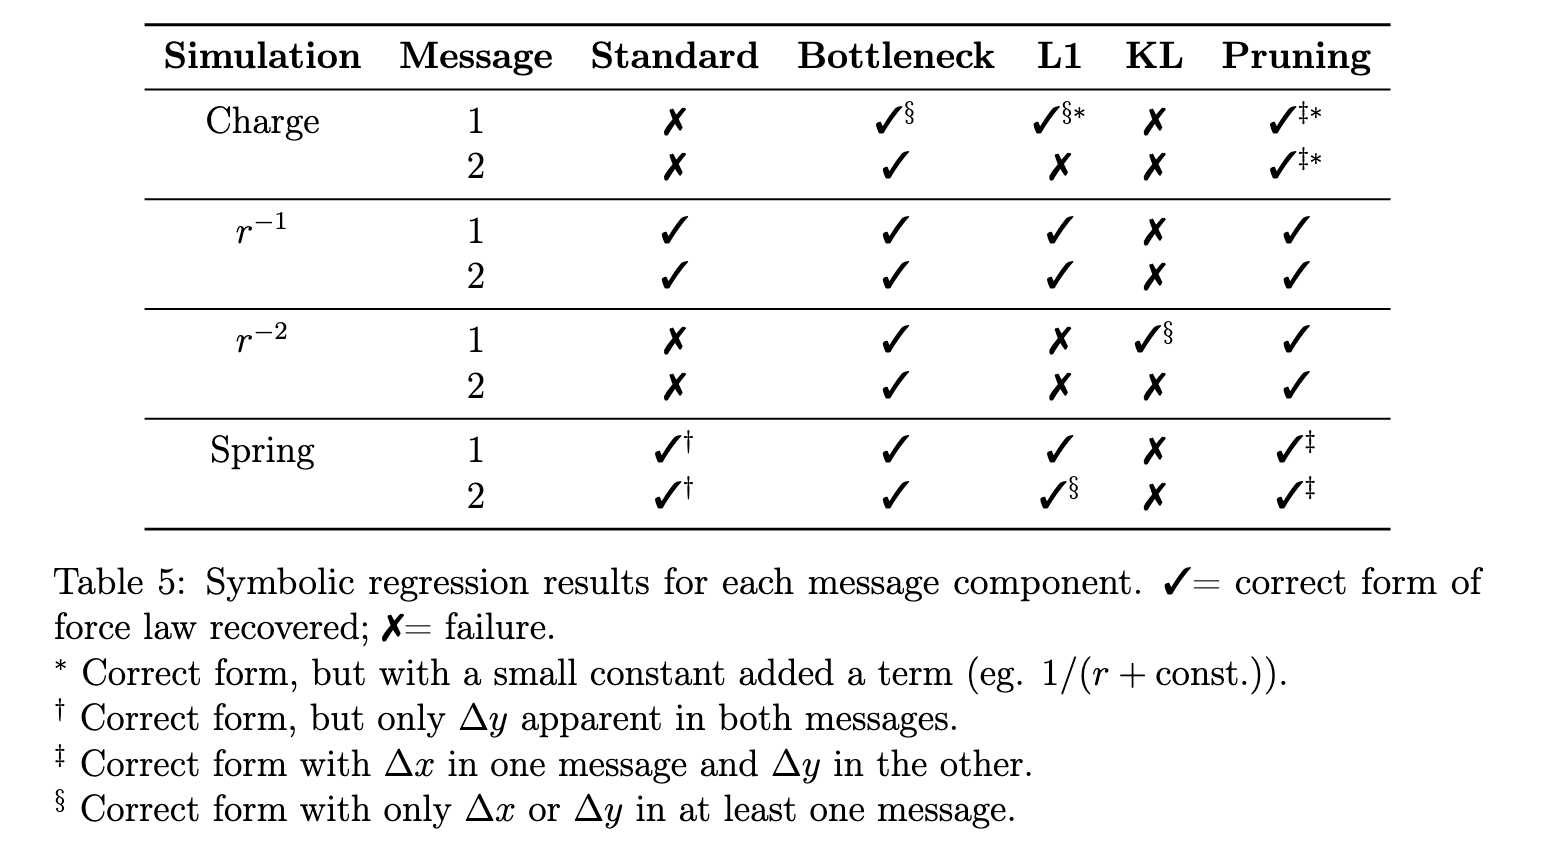

You may get differing results than shown here, especially if you don't train for 200 epochs.

Run the symbolic regression for 6000 iterations to allow the Pareto front to stabilise.\
The first time you run this the Julia dependencies will be installed which may take some time.

In [40]:
from symbolic_reg import *

In [41]:
#the target messages are the most important message elements
target_messages, variables, names = get_pysr_variables(model, test_data)
target_message1, target_message2 = target_messages

Variables considered in the SR are ['dx', 'dy', 'bd', 'm1', 'm2', 'q1', 'q2'].
Getting messages.


In [42]:
#how many rounds of evolution do you want
#typically 6000-7000 is enough for the Pareto front to stabilise
niterations = 1000

For $\texttt{niterations = 1000}$, the SR takes around 10 minutes.

In [44]:
save_path = f'pysr_objects/{sim}/nit_{niterations}/{model_type}' #where we will save the pysr objects
os.makedirs(save_path, exist_ok=True)
os.makedirs(f'{save_path}/message1', exist_ok=True)
os.makedirs(f'{save_path}/message2', exist_ok=True)

In [49]:
#perform SR on msg1
regressor = perform_sr(target_message1, variables, num_points = 6_000, #this is the number of examples to give
                    niterations=niterations, dataset_name = sim, save_path=save_path, message_number='message1', variable_names=names)
#Uncomment if you want to perform SR on msg2

# regressor2 = perform_sr(target_message2, variables, num_points = 6_000,
#                     niterations=niterations, dataset_name = sim, save_path=save_path, message_number='message2', variable_names=names)

Performing SR on the messages.


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.800e+03
Progress: 203 / 31000 total iterations (0.655%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.152e-01  0.000e+00  y = 0.059532
3           6.118e-01  1.435e-01  y = dy * -0.58439
4           6.118e-01  2.384e-06  y = dy * inv(-1.7052)
5           5.074e-01  1.871e-01  y = (dy * r) * -0.33815
7           4.651e-01  4.347e-02  y = (dx + (dy * 1.905)) * -0.42848
8           4.350e-01  6.698e-02  y = (log(r) * dy) * -1.0803
10          3.879e-01  5.730e-02  y = inv((inv(dy + dx) * -3.7194) * inv(r))
19          1.754e-01  8.818e-02  y = (((inv(inv(dy)) * log(r)) * 1.8983) + (dx * log(r))) *...
                                       -0.62545
──────────────────────────────────────────────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.520e+03
Progress: 30878 / 31000 total iterations (99.606%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.152e-01  0.000e+00  y = 0.058005
3           6.118e-01  1.435e-01  y = dy * -0.58581
5           5.074e-01  9.358e-02  y = (dy * -0.34126) * r
6           4.498e-01  1.205e-01  y = (inv(r) + -1.1775) * dy
7           3.288e-01  3.133e-01  y = ((dy * r) + dx) * -0.38394
8           2.766e-01  1.730e-01  y = (inv(r) + -1.0841) * (dx + dy)
9           2.620e-01  5.404e-02  y = (((dx * 0.55065) + dy) * -0.37803) * r
10          8.266e-02  1.154e+00  y = ((dy * 1.7487) + dx) * (inv(r) + -0.97955)
12          6.620e-02  1.111e-01  y = (((dy * 1.7365) + dx) * (inv(r) + -0.99039)) + 0.04226...
                                      2
14          5

You can check the Pareto front of equations by running the below cell. See if the model managed to reconstruct the true force.

In [52]:
regressor.equations_

,complexity,loss,equation,score,sympy_format,lambda_format
0,1,0.815214,0.05800453,0.000000,0.0580045300000000,PySRFunction(X=>0.0580045300000000)
1,3,0.611795,dy * -0.5858117,0.143527,dy*(-0.5858117),PySRFunction(X=>dy*(-0.5858117))
2,5,0.507369,(dy * -0.34126142) * r,0.093579,dy*(-0.34126142)*r,PySRFunction(X=>dy*(-0.34126142)*r)
3,6,0.449751,(inv(r) + -1.1774503) * dy,0.120545,dy*(-1.1774503 + 1/r),PySRFunction(X=>dy*(-1.1774503 + 1/r))
4,7,0.328776,((dy * r) + dx) * -0.3839413,0.313316,(dx + dy*r)*(-0.3839413),PySRFunction(X=>(dx + dy*r)*(-0.3839413))
5,8,0.276558,(inv(r) + -1.0840719) * (dx + dy),0.172957,(-1.0840719 + 1/r)*(dx + dy),PySRFunction(X=>(-1.0840719 + 1/r)*(dx + dy))
6,9,0.262009,(((dx * 0.55064684) + dy) * -0.37802863) * r,0.054040,(dx*0.55064684 + dy)*(-0.37802863)*r,PySRFunction(X=>(dx*0.55064684 + dy)*(-0.37802...
7,10,0.082659,((dy * 1.7486614) + dx) * (inv(r) + -0.97954774),1.153655,(-0.97954774 + 1/r)*(dx + dy*1.7486614),PySRFunction(X=>(-0.97954774 + 1/r)*(dx + dy*1...
8,12,0.066195,(((dy * 1.7364907) + dx) * (inv(r) + -0.990391...,0.111058,(-0.9903916 + 1/r)*(dx + dy*1.7364907) + 0.042...,PySRFunction(X=>(-0.9903916 + 1/r)*(dx + dy*1....
9,14,0.057798,((((dy * 1.8048141) + dx) * (inv(r) + -0.99929...,0.067828,((-0.99929184 + 1/r)*(dx + dy*1.8048141) + 0.0...,PySRFunction(X=>((-0.99929184 + 1/r)*(dx + dy*...


You can check what equation *PySR* chooses as the best equation. This is not always the one that reconstructs the forces.

In [53]:
regressor.get_best()['equation']

'((((m_one * -0.04858595) + 0.9928902) * (inv(r) + -1.0002463)) * ((dy * 1.8037989) + dx)) + 0.04324419'